In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import os

In [3]:
dir = os.getcwd()
dir

'C:\\Users\\vassi\\Documents\\GitHub\\Exploring_PINN\\Daphnia_Magna_uptake\\First_try'

In [4]:
C1_data = pd.read_csv(os.path.join(dir, 'C1_data.csv'))
C2_data = pd.read_csv(os.path.join(dir, 'C2_data.csv'))
C3_data = pd.read_csv(os.path.join(dir, 'C3_data.csv'))

C3_data

Unnamed: 0       Time   TiO2-T1   TiO2-T2   TiO2-H1   TiO2-S1   TiO2-H2  \
0           1   0.166667  0.013636  0.030519  0.020130  0.016883  0.025325   
1           2   0.333333  0.020455  0.051299  0.032143  0.054870  0.042208   
2           3   0.666667  0.043182  0.078571  0.062662  0.105195  0.082143   
3           4   1.000000  0.073701  0.129221  0.092857  0.139286  0.097078   
4           5   2.000000  0.098563  0.173581  0.130541  0.169566  0.149202   
5           6   5.000000  0.092005  0.151771  0.115211  0.117369  0.137979   
6           7   8.000000  0.083306  0.134457  0.102068  0.093822  0.126501   
7           8  14.000000  0.073372  0.115150  0.098396  0.080852  0.109693   
8           9  26.000000  0.064270  0.100550  0.080480  0.069510  0.097290   

    TiO2-S2  
0  0.046104  
1  0.088636  
2  0.167208  
3  0.189610  
4  0.180954  
5  0.158218  
6  0.150113  
7  0.136397  
8  0.123640

In [5]:
df = C3_data[['Time', 'TiO2-T1']]
df.loc[0] = [0,0]
df

C:\Users\vassi\AppData\Local\Temp\ipykernel_14440\493284317.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[0] = [0,0]


Time   TiO2-T1
0   0.000000  0.000000
1   0.333333  0.020455
2   0.666667  0.043182
3   1.000000  0.073701
4   2.000000  0.098563
5   5.000000  0.092005
6   8.000000  0.083306
7  14.000000  0.073372
8  26.000000  0.064270

In [6]:
x = df[['Time']]
x = torch.tensor(x.values).to(torch.float32)
y = torch.tensor(df[['TiO2-T1']].values).to(torch.float32)
print(x)
print(y)


tensor([[ 0.0000],
        [ 0.3333],
        [ 0.6667],
        [ 1.0000],
        [ 2.0000],
        [ 5.0000],
        [ 8.0000],
        [14.0000],
        [26.0000]])
tensor([[0.0000],
        [0.0205],
        [0.0432],
        [0.0737],
        [0.0986],
        [0.0920],
        [0.0833],
        [0.0734],
        [0.0643]])


In [7]:
print(x.dtype)
print(y.dtype)

torch.float32
torch.float32


In [8]:
n_input, n_hidden, n_out, learning_rate, epochs = 1, 100, 1, 0.25, 5000

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=1, bias=True)
  (9): Sigmoid()
)


In [9]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [10]:
scores = []
for epoch in range(epochs):
    pred_y = model(x)
    loss = loss_function(pred_y, y)
    scores.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

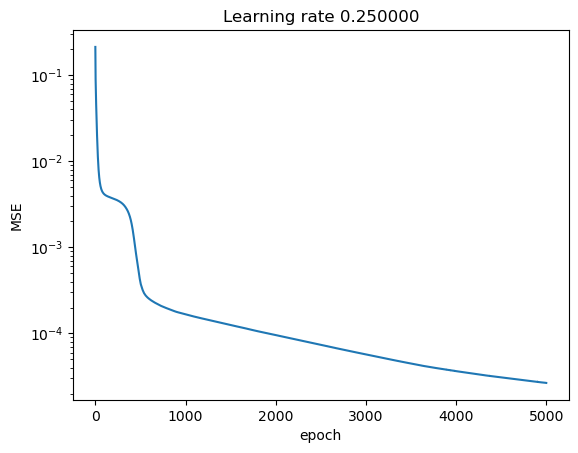

In [11]:
import matplotlib.pyplot as plt
plt.plot(scores)
plt.yscale("log")  
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [12]:
t_new = np.arange(0, 27.05, 0.1)
#t_new = np.transpose(t_new)
t_new

#x_new = np.column_stack((t_new,exposure_new))
x_new = torch.tensor(t_new).to(torch.float32)
x_new = torch.reshape(x_new, (len(t_new), 1))
#x_new
y_new = model(x_new)


In [13]:
type(x_new)
type(y_new)
columns = ['Time', 'y_pred']
plot_df = torch.cat((x_new, y_new), 1)
plot_df = pd.DataFrame(plot_df.detach().numpy(), columns=columns)
plot_df

Time    y_pred
0     0.000000  0.013559
1     0.100000  0.015779
2     0.200000  0.018470
3     0.300000  0.021774
4     0.400000  0.025735
..         ...       ...
266  26.600000  0.060945
267  26.700001  0.060655
268  26.799999  0.060365
269  26.900000  0.060076
270  27.000000  0.059789

[271 rows x 2 columns]

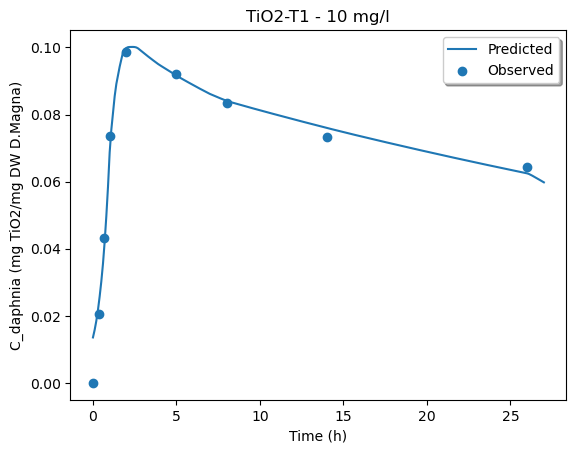

In [14]:
plt.plot(plot_df['Time'], plot_df['y_pred'])
plt.scatter(df['Time'],df['TiO2-T1'])
plt.ylabel('C_daphnia (mg TiO2/mg DW D.Magna)')
plt.xlabel('Time (h)')
plt.title('TiO2-T1 - 10 mg/l')
plt.legend(['Predicted', 'Observed'], shadow=True)
plt.show()

In [130]:
df = C2_data[['Time', 'TiO2-T1']]
df.loc[0] = [0,0]
df

C:\Users\vassi\AppData\Local\Temp\ipykernel_14440\2326731745.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[0] = [0,0]


Time   TiO2-T1
0   0.000000  0.000000
1   0.333333  0.006791
2   0.666667  0.012377
3   1.000000  0.015954
4   2.000000  0.035927
5   5.000000  0.029868
6   8.000000  0.024784
7  14.000000  0.022624
8  26.000000  0.021470

In [131]:
scaler=MinMaxScaler()
df_scaled = scaler.fit_transform(df)
columns = ['Time', 'TiO2-T1']
df_scaled = pd.DataFrame(df_scaled, columns=columns)
df_scaled

Time   TiO2-T1
0  0.000000  0.000000
1  0.012821  0.189017
2  0.025641  0.344494
3  0.038462  0.444065
4  0.076923  1.000000
5  0.192308  0.831357
6  0.307692  0.689823
7  0.538462  0.629720
8  1.000000  0.597595

In [146]:
x = df_scaled[['Time']]
x = torch.tensor(x.values).to(torch.float32)
y = torch.tensor(df_scaled[['TiO2-T1']].values).to(torch.float32)
print(x)
print(y)


tensor([[0.0000],
        [0.0128],
        [0.0256],
        [0.0385],
        [0.0769],
        [0.1923],
        [0.3077],
        [0.5385],
        [1.0000]])
tensor([[0.0000],
        [0.1890],
        [0.3445],
        [0.4441],
        [1.0000],
        [0.8314],
        [0.6898],
        [0.6297],
        [0.5976]])


In [147]:
print(x.dtype)
print(y.dtype)

torch.float32
torch.float32


In [148]:
n_input, n_hidden, n_out, learning_rate, epochs = 1, 100, 1, 0.25, 5000

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=1, bias=True)
  (9): Sigmoid()
)


In [149]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [150]:
scores = []
for epoch in range(epochs):
    pred_y = model(x)
    loss = loss_function(pred_y, y)
    scores.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

In [151]:
model(x)

tensor([[0.0528],
        [0.1058],
        [0.2059],
        [0.3584],
        [0.9598],
        [0.8391],
        [0.6879],
        [0.6289],
        [0.5935]], grad_fn=<SigmoidBackward0>)

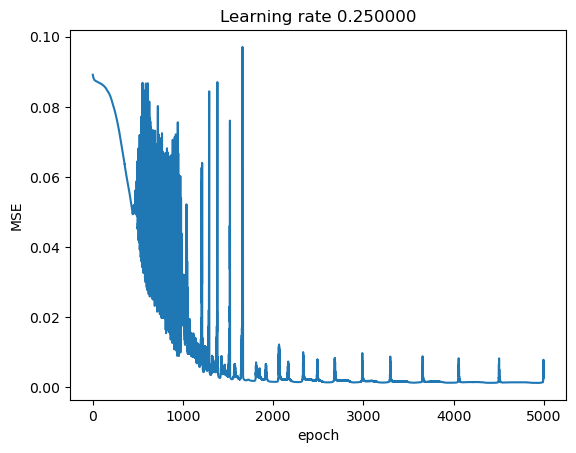

In [152]:
plt.plot(scores)
#plt.yscale("log")  
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [153]:
t_new = np.arange(0, 1.005, 0.01)
#t_new = np.transpose(t_new)
t_new

#x_new = np.column_stack((t_new,exposure_new))
x_new = torch.tensor(t_new).to(torch.float32)
x_new = torch.reshape(x_new, (len(t_new), 1))
#x_new
y_new = model(x_new)


In [157]:
type(x_new)
type(y_new)
columns = ['Time', 'y_pred']#, 'y_true']
plot_df = torch.cat((x_new, y_new), 1)
plot_df = pd.DataFrame(plot_df.detach().numpy(), columns=columns)
plot_df = pd.DataFrame(scaler.inverse_transform(plot_df), columns=columns)
plot_df

Time    y_pred
0     0.000000  0.001895
1     0.260000  0.003253
2     0.520000  0.005572
3     0.780000  0.009082
4     1.040000  0.013636
..         ...       ...
96   24.959999  0.021408
97   25.220001  0.021387
98   25.480000  0.021365
99   25.740000  0.021344
100  26.000000  0.021322

[101 rows x 2 columns]

In [158]:
columns = ['Time', 'TiO2-T1']
df = pd.DataFrame(scaler.inverse_transform(df_scaled), columns=columns)

In [159]:
df

Time   TiO2-T1
0   0.000000  0.000000
1   0.333333  0.006791
2   0.666667  0.012377
3   1.000000  0.015954
4   2.000000  0.035927
5   5.000000  0.029868
6   8.000000  0.024784
7  14.000000  0.022624
8  26.000000  0.021470

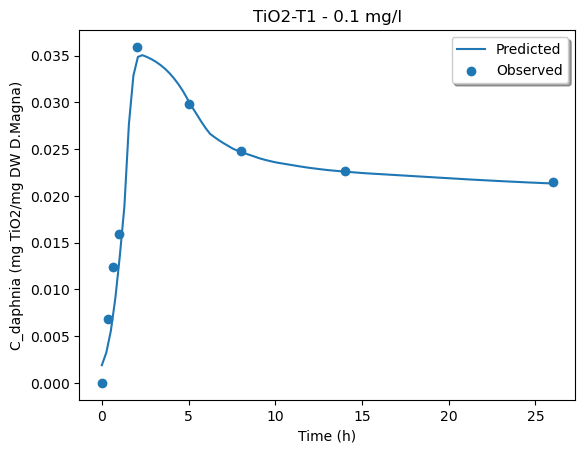

In [160]:
plt.plot(plot_df['Time'], plot_df['y_pred'])
plt.scatter(df['Time'],df['TiO2-T1'])
plt.ylabel('C_daphnia (mg TiO2/mg DW D.Magna)')
plt.xlabel('Time (h)')
plt.title('TiO2-T1 - 0.1 mg/l')
plt.legend(['Predicted', 'Observed'], shadow=True)
plt.show()

### Fit and predict the 3 different concentrations for the same NP type (TiO2-T1)

In [251]:
exposure = np.concatenate((np.repeat(0.1,C1_data.shape[0]),np.repeat(1,C1_data.shape[0]),np.repeat(10,C1_data.shape[0])))
df = pd.concat([C1_data[['Time', 'TiO2-T1']], C2_data[['Time', 'TiO2-T1']], C3_data[['Time', 'TiO2-T1']]], ignore_index=True)
df.insert(1, 'Exposure', exposure)
df

Time  Exposure   TiO2-T1
0    0.166667       0.1  0.000458
1    0.333333       0.1  0.000669
2    0.666667       0.1  0.001102
3    1.000000       0.1  0.001536
4    2.000000       0.1  0.002833
5    5.000000       0.1  0.001986
6    8.000000       0.1  0.001695
7   14.000000       0.1  0.001537
8   26.000000       0.1  0.001120
9    0.166667       1.0  0.004141
10   0.333333       1.0  0.006791
11   0.666667       1.0  0.012377
12   1.000000       1.0  0.015954
13   2.000000       1.0  0.035927
14   5.000000       1.0  0.029868
15   8.000000       1.0  0.024784
16  14.000000       1.0  0.022624
17  26.000000       1.0  0.021470
18   0.166667      10.0  0.013636
19   0.333333      10.0  0.020455
20   0.666667      10.0  0.043182
21   1.000000      10.0  0.073701
22   2.000000      10.0  0.098563
23   5.000000      10.0  0.092005
24   8.000000      10.0  0.083306
25  14.000000      10.0  0.073372
26  26.000000      10.0  0.064270

In [252]:
df_scaled = scaler.fit_transform(df)
columns = ['Time', 'Exposure', 'TiO2-T1']
df_scaled = pd.DataFrame(df_scaled, columns=columns)
df_scaled

Time  Exposure   TiO2-T1
0   0.000000  0.000000  0.000000
1   0.006452  0.000000  0.002146
2   0.019355  0.000000  0.006564
3   0.032258  0.000000  0.010982
4   0.070968  0.000000  0.024205
5   0.187097  0.000000  0.015573
6   0.303226  0.000000  0.012610
7   0.535484  0.000000  0.010996
8   1.000000  0.000000  0.006746
9   0.000000  0.090909  0.037543
10  0.006452  0.090909  0.064550
11  0.019355  0.090909  0.121489
12  0.032258  0.090909  0.157953
13  0.070968  0.090909  0.361545
14  0.187097  0.090909  0.299785
15  0.303226  0.090909  0.247953
16  0.535484  0.090909  0.225943
17  1.000000  0.090909  0.214178
18  0.000000  1.000000  0.134328
19  0.006452  1.000000  0.203827
20  0.019355  1.000000  0.435492
21  0.032258  1.000000  0.746584
22  0.070968  1.000000  1.000000
23  0.187097  1.000000  0.933157
24  0.303226  1.000000  0.844490
25  0.535484  1.000000  0.743230
26  1.000000  1.000000  0.650448

In [253]:
x = df_scaled[['Time', 'Exposure']]
x = torch.tensor(x.values).to(torch.float32)
y = torch.tensor(df_scaled[['TiO2-T1']].values).to(torch.float32)

In [254]:
n_input, n_hidden, n_out, learning_rate, epochs = 2, 1000, 1, 0.25, 5000

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1000, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1000, out_features=1000, bias=True)
  (3): ReLU()
  (4): Linear(in_features=1000, out_features=1000, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1000, out_features=1000, bias=True)
  (7): ReLU()
  (8): Linear(in_features=1000, out_features=1, bias=True)
  (9): Sigmoid()
)


In [255]:
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [256]:
scores = []
for epoch in range(epochs):
    pred_y = model(x)
    loss = loss_function(pred_y, y)
    scores.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

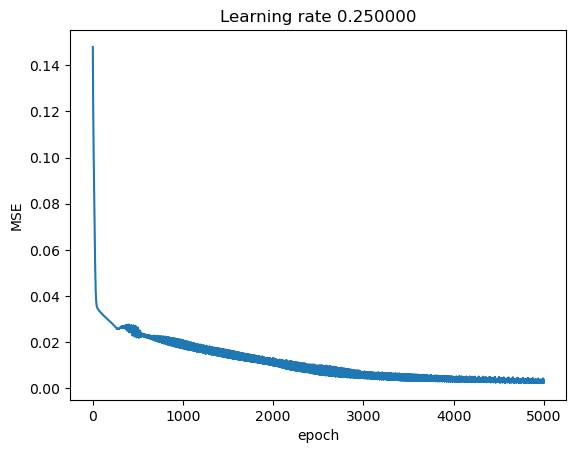

In [257]:
plt.plot(scores)
#plt.yscale("log")  
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [258]:
t_new = np.arange(0, 26.5, 1)
exposure = np.concatenate((np.tile(0.1,len(t_new)),np.tile(1,len(t_new)),np.tile(10,len(t_new))))
x_new = np.column_stack((np.tile(t_new, 3), exposure, np.tile(1, len(t_new)*3)))
x_new_scaled = scaler.transform(x_new)
x_new_scaled = torch.tensor(x_new_scaled[:,[0,1]]).to(torch.float32)
y_new = model(x_new_scaled)

columns = ['Time', 'Exposure', 'y_pred']
x_new_scaled = x_new_scaled.detach().numpy()
y_new = y_new.detach().numpy()
#plot_df = torch.cat((x_new_scaled, y_new), 1)
plot_df = np.column_stack((x_new_scaled, y_new))
plot_df = pd.DataFrame(scaler.inverse_transform(plot_df), columns=columns)
#plot_df = pd.DataFrame(scaler.inverse_transform(plot_df), columns=columns)
#df['DataFrame column'].round(decimals = number of decimal places needed)
plot_df['Exposure'] = plot_df['Exposure'].round(decimals=1)
plot_df

C:\Users\vassi\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Time  Exposure    y_pred
0   2.561138e-09       0.1  0.001250
1   1.000000e+00       0.1  0.001773
2   2.000000e+00       0.1  0.002998
3   3.000000e+00       0.1  0.002907
4   4.000000e+00       0.1  0.002658
..           ...       ...       ...
76  2.200000e+01      10.0  0.065056
77  2.300000e+01      10.0  0.064128
78  2.400000e+01      10.0  0.063166
79  2.500000e+01      10.0  0.062199
80  2.600000e+01      10.0  0.061235

[81 rows x 3 columns]

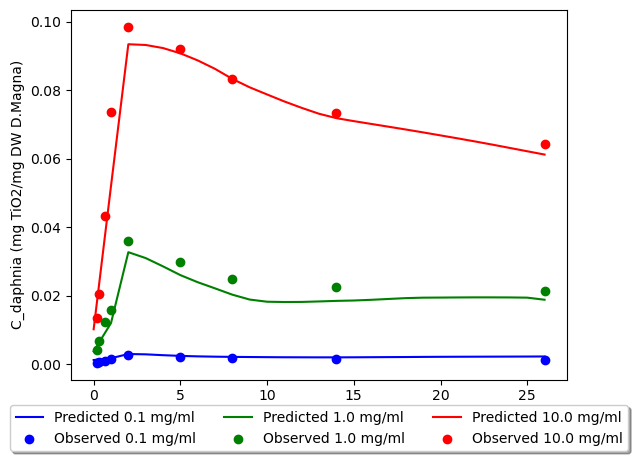

In [264]:
plt.plot(plot_df['Time'].loc[plot_df['Exposure']==0.1], plot_df['y_pred'].loc[plot_df['Exposure']==0.1], color='b')
plt.scatter(df['Time'].loc[df['Exposure']==0.1],df['TiO2-T1'].loc[df['Exposure']==0.1], color='b')
plt.plot(plot_df['Time'].loc[plot_df['Exposure']==1.0], plot_df['y_pred'].loc[plot_df['Exposure']==1.0], color='g')
plt.scatter(df['Time'].loc[df['Exposure']==1.0],df['TiO2-T1'].loc[df['Exposure']==1.0], color='g')
plt.plot(plot_df['Time'].loc[plot_df['Exposure']==10.0], plot_df['y_pred'].loc[plot_df['Exposure']==10.0], color='r')
plt.scatter(df['Time'].loc[df['Exposure']==10.0],df['TiO2-T1'].loc[df['Exposure']==10.0], color='r')

plt.ylabel('C_daphnia (mg TiO2/mg DW D.Magna)')
#plt.yscale("log")  
plt.xlabel('Time (h)')
#plt.title('TiO2-T1 - 10 mg/l')
plt.legend(['Predicted 0.1 mg/ml', 'Observed 0.1 mg/ml',
           'Predicted 1.0 mg/ml', 'Observed 1.0 mg/ml',
           'Predicted 10.0 mg/ml', 'Observed 10.0 mg/ml'], 
          loc='upper center', bbox_to_anchor=(0.5, -0.05),
          ncol=3, fancybox=True, shadow=True)
plt.show()